In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

###### 求解各部门的离职分布

0.2891069046174478


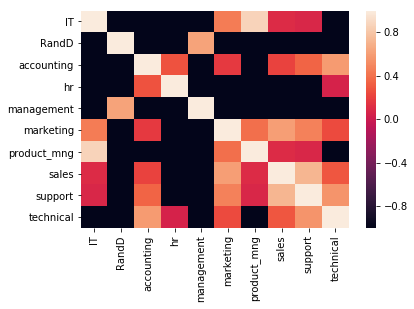

In [18]:
file_name = 'd:\HR.csv'
reader = pd.read_csv(file_name)
dp_indices=reader.groupby(by='sales').indices
sales_values=reader['left'].iloc[dp_indices['sales']].values
#iloc 是下标的意思...
techinical_values=reader['left'].iloc[dp_indices['technical']].values
print(ss.ttest_ind(sales_values,techinical_values)[1])#1为索引可以得到p值
dp_keys = list(dp_indices.keys())#两两求p值
dp_t_mat = np.zeros([len(dp_keys), len(dp_keys)])#初始化
for i in range(len(dp_keys)):
    for j in range(len(dp_keys)):
        p_value = ss.ttest_ind(reader['left'].iloc[dp_indices[dp_keys[i]]].values,\
                               reader['left'].iloc[dp_indices[dp_keys[j]]].values)[1]
        if p_value<0.05:
            dp_t_mat[i][j] = -1
        else:
            dp_t_mat[i][j] = p_value
sns.heatmap(dp_t_mat,xticklabels=dp_keys,yticklabels=dp_keys)#颜色越深的地方表现出有显著差异的
plt.show()

###### 交叉分析 透视表

In [19]:
piv_tb = pd.pivot_table(reader,values='left',index=['promotion_last_5years','salary'],\
                        columns=['Work_accident'],aggfunc=np.mean)#聚合函数的参数为mean
print(piv_tb)#可以看到在表中没有工作事故但是工资5年低的人离职率比较高，需要关注。

Work_accident                        0         1
promotion_last_5years salary                    
0                     high    0.082996  0.000000
                      low     0.331728  0.090020
                      medium  0.230683  0.081655
1                     high    0.000000  0.000000
                      low     0.229167  0.166667
                      medium  0.028986  0.023256


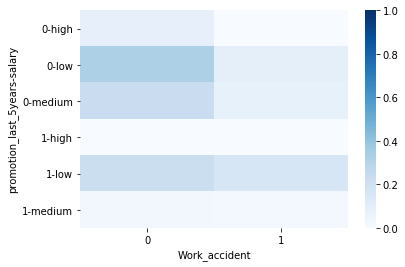

In [26]:
sns.heatmap(piv_tb,vmin=0,vmax=1,cmap=sns.color_palette('Blues',n_colors=256))
plt.show()#颜色深的离职率高，需要重点关注

###### 分组与钻取 用于辅助

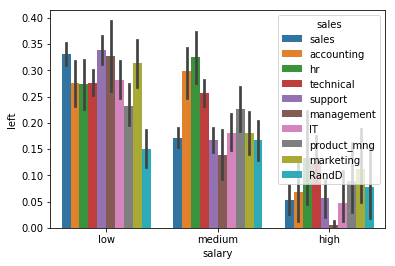

In [28]:
sns.set_context(font_scale=1.5)
sns.barplot(x='salary',y='left',hue='sales',data=reader)
plt.show()

In [55]:
sl_s=reader['satisfaction_level']
sns.barplot(list(range(len(sl_s))),sl_s.sort_values)
plt.show(

SyntaxError: unexpected EOF while parsing (<ipython-input-55-0e993c5c1a55>, line 3)

###### 相关分析

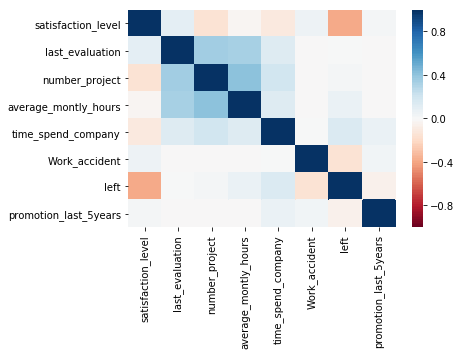

In [40]:
sns.heatmap(reader.corr(),vmin=-1,vmax=1,cmap=sns.color_palette('RdBu',n_colors=128))
plt.show()#看出正负相关度

In [44]:
s1=pd.Series(['x1','x1','x2','x2','x2','x2'])
s2=pd.Series(['y1','y1','y1','y2','y2','y2'])
def getEntropy(s):
    prt_ary=pd.Series.groupby(s,by=s).count().values/float(len(s))#求出概率分布
    return -(np.log2(prt_ary)*prt_ary).sum()#求出熵,s2分布均匀所以为1
print("Entropy:",getEntropy(s1))

Entropy: 0.9182958340544896


In [48]:
def getCondEntropy(s1,s2):
    d=dict()
    for i in list(range(len(s1))):
        d[s1[i]]=d.get(s1[i],[])+[s2[i]]#用数组记录，s1下s2的分布，数组中都是s2值
    return sum([getEntropy(d[k])*len(d[k])/float(len(s1))for k in d])#先计算x1情况下的熵，在计算x2情况下熵
print(getCondEntropy(s1,s2)

SyntaxError: unexpected EOF while parsing (<ipython-input-48-f9d1afbe2d3e>, line 6)

In [50]:
def getEntropyGain(s1,s2):#熵增益
    return getEntropy(s2)-getCondEntropy(s1,s2)
import math
def getDiscreteCorr(s1,s2):
    return getEntropyGain(s1,s2)/math.sqrt(getEntropy(s1)*getEntropy(s2))

###### 求Gini 不纯度

In [54]:
def getProbSS(s):
    if not isinstance(s,pd.core.series.Series):
        s = pd.Series(s)
    prt_ary = pd.Series.groupby(s,by=s).count().values/float(len(s))
    return sum(prt_ary**2)
def getGini(s1,s2):
    d= dict()
    for i in list(range(len(s1))):
        d[s1[i]] = d.get(s1[i],[])+[s2[i]]
    return 1- sum([getProbSS(d[k])*len(d[k])/float(len(s1)) for k in d])
print(getGini(s1,s2))
print(getGini(s2,s1))#非对称

0.25
0.2222222222222222


###### 因子分析法 引入主成分分析

ratio: [9.98565340e-01 8.69246970e-04 4.73865973e-04 4.96932182e-05
 2.43172315e-05 9.29496619e-06 8.24128218e-06]


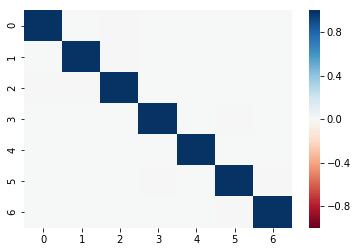

In [58]:
from sklearn.decomposition import PCA
my_pca = PCA(n_components=7)
lower_mat = my_pca.fit_transform(reader.drop(labels=['left','salary','sales'],axis=1))#默认为行
print("ratio:",my_pca.explained_variance_ratio_)
sns.heatmap(pd.DataFrame(lower_mat).corr(),vmin=-1,vmax=1,cmap=sns.color_palette("RdBu",n_colors=128))
plt.show()#正交